## SRPT vs. BASRPT

In [23]:
%load_ext autoreload
import trafpy
import trafpy.generator as tpg

import os
import pickle
import matplotlib.pyplot as plt

path_to_benchmark_data = os.path.dirname(trafpy.__file__)+'/../data/testbed_data/ndf50_1s_university_testbed_data_v3.obj'
filehandler = open(path_to_benchmark_data, 'rb')
tb_dict = pickle.load(filehandler)

print(tb_dict.keys())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dict_keys(['benchmark_data', 'benchmarks', 'envs', 'config'])


In [24]:
%autoreload
envs = tb_dict['envs']
print(envs)

[<trafpy.manager.src.simulators.dcn.DCN object at 0x7ff1085a2070>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7ff00885d160>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7feff74f4fd0>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7ff00465fe80>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7ff0151a8310>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7ff01686e490>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7ff01546b130>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fefeb8d5d30>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fefffa02df0>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fefe4d3c880>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fefe1b8b370>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fefdf3c4fd0>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7feffd9f7940>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fefd73ae940>, <trafpy.manager.src.simulators.dcn.DCN object at 0x7fefd4c06d00>, <trafpy.m

## TODO

### Key Stats to Compare
- Average flow completion time
- 99th percentile flow completion time
- Queue length
- Throughput

### Key Plots

In [25]:
%autoreload
for env in envs:
    print('Net capacity: {}'.format(env.network.graph['max_nw_capacity']))
    print(env.get_scheduling_session_summary(print_summary=True))

Net capacity: 12
-=-=-=-=-=-=-= Scheduling Session Ended -=-=-=-=-=-=-=
SUMMARY:
~* General Info *~
Simulation name: 'benchmark_university_load_0.1_repeat_0_scheduler_basrpt'
Total session duration: 8396000.0 time units
Total number of generated demands (jobs or flows): 3000
Total info arrived: 9692671.0 info units
Load: 1.162527826431793 info unit demands arrived per unit time (from first to last flow arriving)
Total info transported: 9692671.0 info units
Throughput: 1.1544391376846117 info units transported per unit time

~* Flow Info *~
Total number generated flows (src!=dst,dependency_type=='data_dep'): 3000
Time first flow arrived: 0.0 time units
Time last flow arrived: 8337581.9310495285 time units
Time first flow completed: 3000.0 time units
Time last flow completed: 8396000.0 time units
Total number of demands that arrived and became flows: 3000
Total number of flows that were completed: 3000
Total number of dropped flows: 0
Total number of flows in queues at end of session: 0


-=-=-=-=-=-=-= Scheduling Session Ended -=-=-=-=-=-=-=
SUMMARY:
~* General Info *~
Simulation name: 'benchmark_university_load_0.7_repeat_0_scheduler_srpt'
Total session duration: 7392000.0 time units
Total number of generated demands (jobs or flows): 12000
Total info arrived: 40410324.0 info units
Load: 8.328396047217856 info unit demands arrived per unit time (from first to last flow arriving)
Total info transported: 17093092.0 info units
Throughput: 2.3123771645021645 info units transported per unit time

~* Flow Info *~
Total number generated flows (src!=dst,dependency_type=='data_dep'): 12000
Time first flow arrived: 0.0 time units
Time last flow arrived: 4852113.632792388 time units
Time first flow completed: 1000.0 time units
Time last flow completed: 7392000.0 time units
Total number of demands that arrived and became flows: 12000
Total number of flows that were completed: 5205
Total number of dropped flows: 6795
Total number of flows in queues at end of session: 0
Average FCT:

In [26]:
%autoreload
# collect testbed stats into dict
testbed_stats = {'test_{}'.format(i): 
                 {envs[i].scheduler.scheduler_name: 
                  {'load_rate': envs[i].load, 
                   'load_frac': envs[i].load/envs[i].network.graph['max_nw_capacity'],
                   'avrg_fct': envs[i].avrg_fct,
                   'nn_fct': envs[i].nn_fct,
                   'q_dict': envs[i].queue_evolution_dict,
                   'throughput': envs[i].throughput}
                 } for i in range(len(envs))}

# find classes
classes = []
for test in testbed_stats.keys():
    for _class in testbed_stats[test].keys():
        if _class not in classes:
            classes.append(_class)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


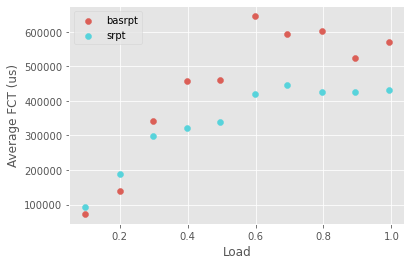

In [27]:
%autoreload
# avrg fct
plot_dict = {_class: {'x_values': [], 'y_values': []} for _class in classes}

for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    plot_dict[_class]['x_values'].append(testbed_stats[test][_class]['load_frac'])
    plot_dict[_class]['y_values'].append(testbed_stats[test][_class]['avrg_fct'])

fig = tpg.plot_val_scatter(plot_dict=plot_dict,xlabel='Load', ylabel='Average FCT (us)', show_fig=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


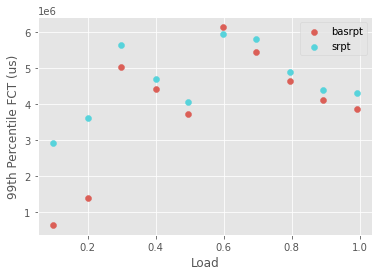

In [28]:
%autoreload
# 99th percentile fct
plot_dict = {_class: {'x_values': [], 'y_values': []} for _class in classes}

for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    plot_dict[_class]['x_values'].append(testbed_stats[test][_class]['load_frac'])
    plot_dict[_class]['y_values'].append(testbed_stats[test][_class]['nn_fct'])

fig = tpg.plot_val_scatter(plot_dict=plot_dict,xlabel='Load', ylabel='99th Percentile FCT (us)', show_fig=True)

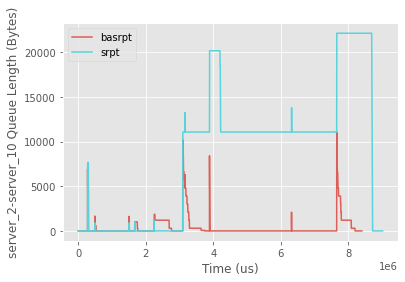

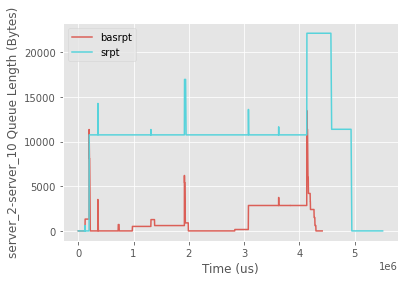

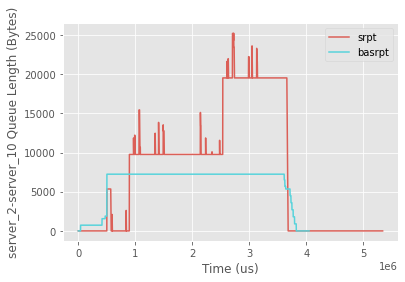

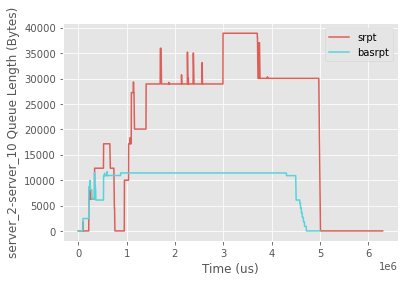

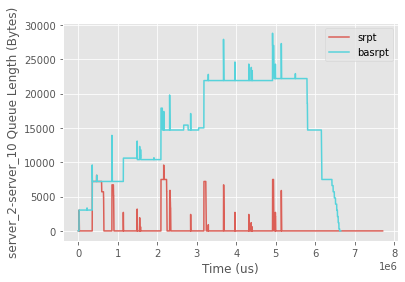

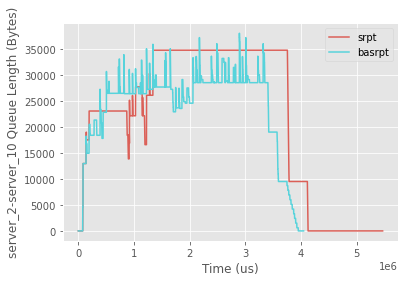

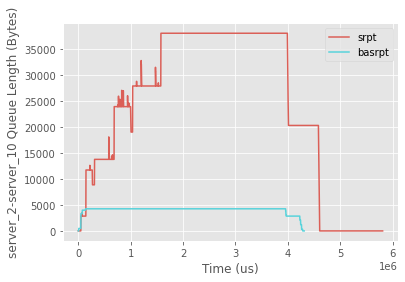

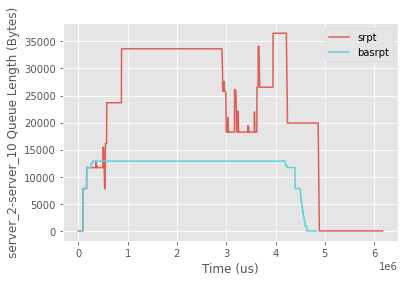

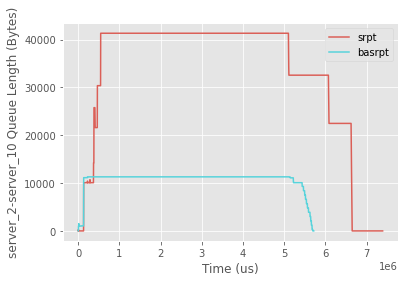

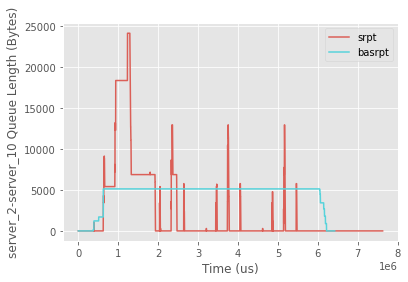

In [29]:
%autoreload
import numpy

# queue length
plot_dict = {}
for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    load = testbed_stats[test][_class]['load_frac']
    try:
        plot_dict[load][_class]['x_values'] = None
        plot_dict[load][_class]['y_values'] = None
    except KeyError:
        # not yet added this load
        try:
            plot_dict[load][_class] = {}
            plot_dict[load][_class]['x_values'] = None
            plot_dict[load][_class]['y_values'] = None
        except KeyError:
            plot_dict[load] = {}
            plot_dict[load][_class] = {}
            plot_dict[load][_class]['x_values'] = None
            plot_dict[load][_class]['y_values'] = None

src = 'server_2'
dst='server_10'
for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    load = testbed_stats[test][_class]['load_frac']
    plot_dict[load][_class]['x_values'] = testbed_stats[test][_class]['q_dict'][src][dst]['times'] 
    plot_dict[load][_class]['y_values'] = testbed_stats[test][_class]['q_dict'][src][dst]['queue_lengths']
    
for load in plot_dict.keys():
    tpg.plot_val_line(plot_dict=plot_dict[load],xlabel='Time (us)', ylabel='{}-{} Queue Length (Bytes)'.format(src,dst), show_fig=True)

{0.0968773188693161: {'x_values': ['b', 's'], 'y_values': [1.1544391376846117, 1.073329782512206]}, 0.1997221951733649: {'x_values': ['b', 's'], 'y_values': [2.3001175537938843, 1.773121437647486]}, 0.49612778818094366: {'x_values': ['s', 'b'], 'y_values': [2.2558131909312347, 2.707451198418582]}, 0.39946802129924747: {'x_values': ['s', 'b'], 'y_values': [2.2335337355135736, 2.5767135718568857]}, 0.2979311549178824: {'x_values': ['s', 'b'], 'y_values': [2.1181151349948077, 2.6867564720048165]}, 0.9930835061643405: {'x_values': ['s', 'b'], 'y_values': [2.4155046626439933, 2.6602832798221785]}, 0.8936470157643993: {'x_values': ['s', 'b'], 'y_values': [2.302386097728837, 2.8050482151135836]}, 0.7967301573194346: {'x_values': ['s', 'b'], 'y_values': [2.425597213220998, 2.557894268570246]}, 0.6940330039348214: {'x_values': ['s', 'b'], 'y_values': [2.3123771645021645, 2.6156112277019936]}, 0.5989870817164099: {'x_values': ['s', 'b'], 'y_values': [2.433198478289387, 2.4444546870133914]}}


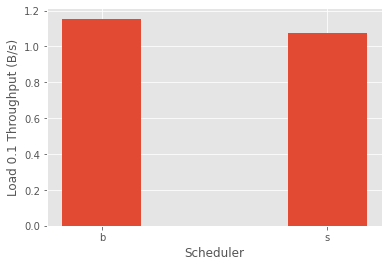

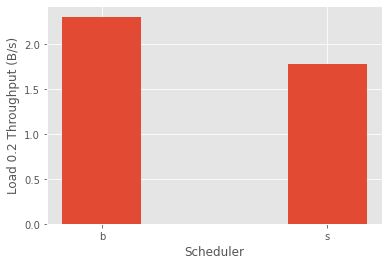

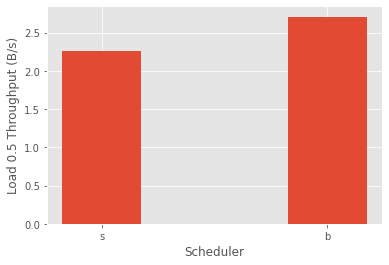

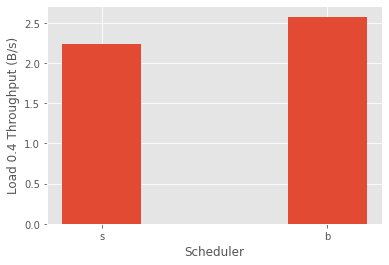

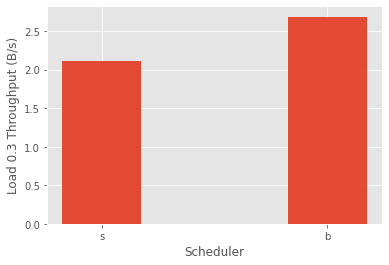

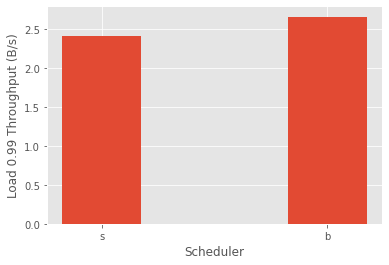

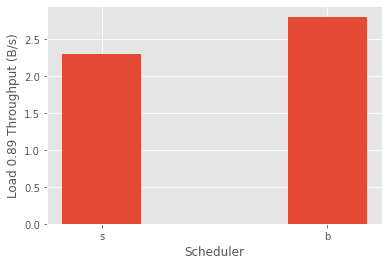

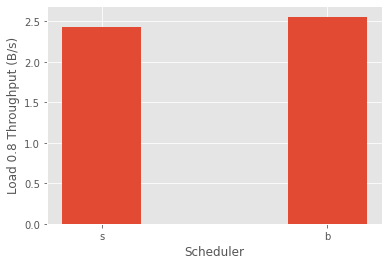

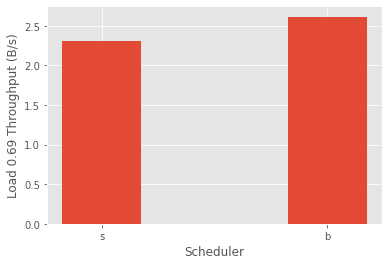

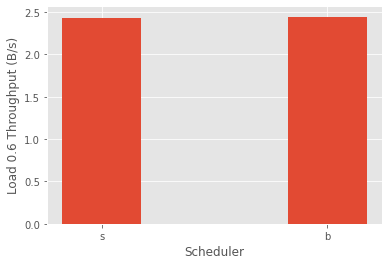

In [30]:
%autoreload
# throughput
plot_dict = {}
for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    load = testbed_stats[test][_class]['load_frac']
    try:
        plot_dict[load]['x_values'].append(_class[0])
        plot_dict[load]['y_values'].append(testbed_stats[test][_class]['throughput'])
    except KeyError:
        try:
            plot_dict[load] = {}
            plot_dict[load]['x_values'].append(_class[0])
            plot_dict[load]['y_values'].append(testbed_stats[test][_class]['throughput'])
        except KeyError:
            plot_dict[load] = {}
            plot_dict[load]['x_values'] = []
            plot_dict[load]['y_values'] = []
            plot_dict[load]['x_values'].append(_class[0])
            plot_dict[load]['y_values'].append(testbed_stats[test][_class]['throughput'])
    
print(plot_dict)
for load in plot_dict.keys():
    tpg.plot_val_bar(x_values=plot_dict[load]['x_values'],y_values=plot_dict[load]['y_values'],xlabel='Scheduler', ylabel='Load {} Throughput (B/s)'.format(str(round(load,2))), show_fig=True)

## Tuning BASRPT

In [ ]:
%autoreload
import trafpy
import trafpy.generator as tpg

import os
import pickle
import matplotlib.pyplot as plt

path_to_benchmark_data = os.path.dirname(trafpy.__file__)+'/../data/testbed_data/ndf10_university_testbed_data_basrpt_tuning.obj'
filehandler = open(path_to_benchmark_data, 'rb')
tb_dict = pickle.load(filehandler)

print(tb_dict.keys())




In [ ]:
envs = tb_dict['envs']
print(envs)

## TODO

### Key Stats to Compare
- Throughput vs. V
- Average FCT vs. V
- 99th Percentile vs. V
- Queue Evolution (V composite)

### Key Plots

In [ ]:
for env in envs:
    print('Net capacity: {}'.format(env.network.graph['max_nw_capacity']))
    print(env.get_scheduling_session_summary(print_summary=True))

In [ ]:
# collect testbed stats into dict
testbed_stats = {'test_{}'.format(i): 
                 {envs[i].scheduler.scheduler_name: 
                  {'load_rate': envs[i].load, 
                   'load_frac': envs[i].load/envs[i].network.graph['max_nw_capacity'],
                   'avrg_fct': envs[i].avrg_fct,
                   'nn_fct': envs[i].nn_fct,
                   'q_dict': envs[i].queue_evolution_dict,
                   'throughput': envs[i].throughput,
                   'V': envs[i].scheduler.V}
                 } for i in range(len(envs))}

# find classes
classes = []
for test in testbed_stats.keys():
    for _class in testbed_stats[test].keys():
        if _class not in classes:
            classes.append(_class)

In [ ]:
# avrg fct
plot_dict = {_class: {'x_values': [], 'y_values': []} for _class in classes}

for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    plot_dict[_class]['x_values'].append(testbed_stats[test][_class]['V'])
    plot_dict[_class]['y_values'].append(testbed_stats[test][_class]['avrg_fct'])

fig = tpg.plot_val_scatter(plot_dict=plot_dict,xlabel='V', ylabel='Average FCT (us)', show_fig=True)

In [ ]:
# 99th percentile fct
plot_dict = {_class: {'x_values': [], 'y_values': []} for _class in classes}

for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    plot_dict[_class]['x_values'].append(testbed_stats[test][_class]['V'])
    plot_dict[_class]['y_values'].append(testbed_stats[test][_class]['nn_fct'])

fig = tpg.plot_val_scatter(plot_dict=plot_dict,xlabel='V', ylabel='99th Percentile FCT (us)', show_fig=True)

In [ ]:
# throughput
plot_dict = {_class: {'x_values': [], 'y_values': []} for _class in classes}

for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    plot_dict[_class]['x_values'].append(testbed_stats[test][_class]['V'])
    plot_dict[_class]['y_values'].append(testbed_stats[test][_class]['throughput'])

fig = tpg.plot_val_scatter(plot_dict=plot_dict,xlabel='V', ylabel='Throughput (B/s)', show_fig=True)

In [ ]:
import numpy

# queue length
plot_dict = {}
for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    load = testbed_stats[test][_class]['load_frac']
    try:
        plot_dict[load][_class]['x_values'] = None
        plot_dict[load][_class]['y_values'] = None
    except KeyError:
        # not yet added this load
        try:
            plot_dict[load][_class] = {}
            plot_dict[load][_class]['x_values'] = None
            plot_dict[load][_class]['y_values'] = None
        except KeyError:
            plot_dict[load] = {}
            plot_dict[load][_class] = {}
            plot_dict[load][_class]['x_values'] = None
            plot_dict[load][_class]['y_values'] = None

src = 'server_2'
dst='server_10'
for test in testbed_stats.keys():
    _class = list(testbed_stats[test].keys())[0]
    load = testbed_stats[test][_class]['load_frac']
    plot_dict[load][_class]['x_values'] = testbed_stats[test][_class]['q_dict'][src][dst]['times'] 
    plot_dict[load][_class]['y_values'] = testbed_stats[test][_class]['q_dict'][src][dst]['queue_lengths']
    
for load in plot_dict.keys():
    tpg.plot_val_line(plot_dict=plot_dict[load],xlabel='Time (us)', ylabel='{}-{} Queue Length (Bytes)'.format(src,dst), show_fig=True)

In [32]:
%autoreload
import trafpy
from trafpy.manager import EnvAnalyser

analyser = EnvAnalyser(env=envs[-1])
analyser.compute_metrics(print_summary=True)



-=-=-=-=-=-=--= Summary -=-=-=-=-=-=-=-

 ~* General Information *~
Simulation name: 'benchmark_university_load_0.6_repeat_0_scheduler_basrpt'
Measurement duration: 4000000.0 (Start time : 0.0 | End time: 4000000)
Total number of generated demands (jobs or flows) passed to env: 12000
Total number of these demands which arrived during measurement period: 8520
Total info arrived: 28850868.0 info unit demands arrived
Total info transported: 11810350.0 info unit demands transported
Load (abs): 7.212717 info unit demands arrived per unit time (from first to last flow arriving)
Load (frac): 0.60105975 fraction of network capacity requested (from first to last flow arriving)
Throughput (abs): 2.9525875 info units transported per unit time
Throughput (frac): 0.4093585676521067 fraction of arrived info successfully transported

 ~* Flow Information *~
Total number of generated flows passed to env (src != dst, dependency_type == 'data_dep')
Total number of these flows which arrived during meas